<a href="https://colab.research.google.com/github/pal-ette/iPetPal/blob/skinoreye/models/binary_classification/resnet18-timm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet18 timm

In [ ]:
# binary classification(eye/others)
# Load resnet-18

from datasets import load_dataset

import os
import shutil
import zipfile
import pandas as pd
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import timm
import tqdm


In [ ]:
# !pip install timm

## Resnet (pretrained model)

In [ ]:
model=timm.create_model('resnet18',pretrained=True,num_classes=2)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!nvidia-smi

Thu May 23 05:29:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              26W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
batch_size = 32
img_size = 224

data_dir = '/kaggle/input/skin-eye-classification'

In [ ]:
for folder in os.listdir(data_dir):
    print(folder, len(os.listdir(os.path.join(data_dir, folder))))

eye 49492
skin 40746


In [ ]:
from torchvision.transforms import (
    Compose,
    ToTensor,
    RandomHorizontalFlip,
    RandomVerticalFlip
)

transforms = Compose(
        [
            ToTensor(),
            RandomHorizontalFlip(),
            RandomVerticalFlip()
        ]
    )



In [ ]:
dataset = datasets.ImageFolder(data_dir, transforms)

In [ ]:
train_size = int(len(dataset)*0.8)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

In [ ]:
print(len(train_dataset), len(valid_dataset))

72183 18046


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
!pip install torchvision

In [ ]:
from torchvision.utils import make_grid

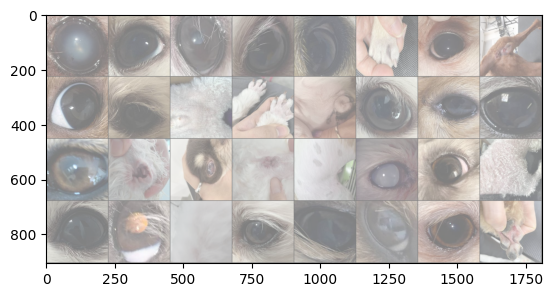

In [ ]:
images, labels = next(iter(train_loader))
imshow(make_grid(images))

['eye', 'skin'] 1


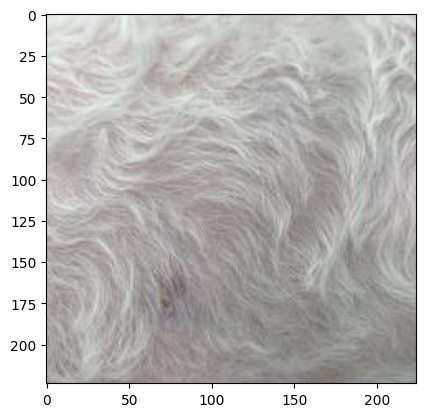

In [ ]:
for data in train_dataset:
    print(dataset.classes, data[1])
    img = data[0].numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()
    break

In [ ]:
def show_images(images, labels, classes, num_images=16):
    images = images[:num_images]  # Select only the first num_images
    labels = labels[:num_images]
    classes = [classes[label] for label in labels]

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, (img, ax, label) in enumerate(zip(images, axes.flatten(), classes)):
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show()

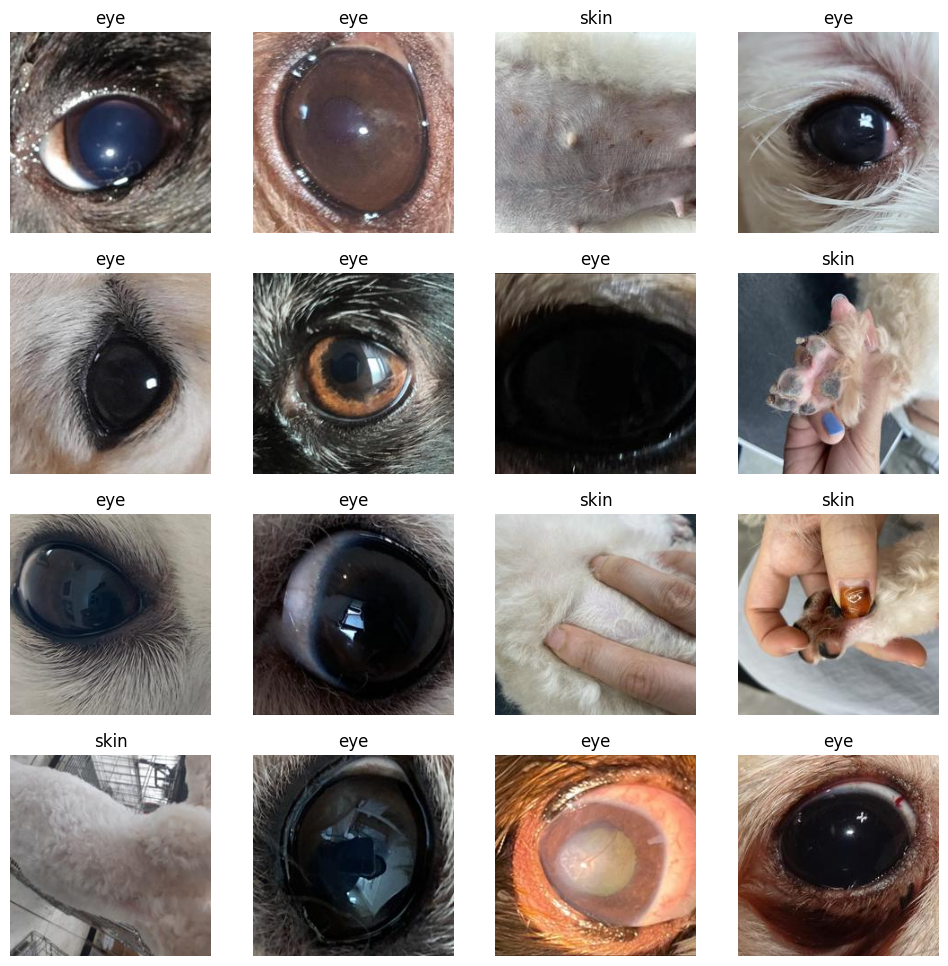

In [ ]:
images, labels = next(iter(train_loader))
show_images(images, labels, dataset.classes)

## Training

In [ ]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5 , momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                          factor=0.05, patience=2)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
from collections import OrderedDict
import pickle

def save_checkpoint(epoch, labels, model, optimizer,
                    train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                    model_path, filename):

    model_dict = OrderedDict([(k, v) for k, v in model.state_dict().items()])
    state = {
        'epoch': epoch,
        'state_dict': model_dict,
        'optimizer': optimizer.state_dict(),
        'label': labels
    }
    torch.save(state, os.path.join(model_path, f'{filename}.pt'))

    config = {"train":{"acc":train_acc_epoch, "loss":train_loss_epoch},
          "valid":{"acc":val_acc_epoch, "loss":val_loss_epoch}}

    with open(os.path.join(model_path, f'{filename}.pickle'),'wb') as fw:
        pickle.dump(config, fw)

In [ ]:
model_path = '/kaggle/working/'
os.makedirs(model_path, exist_ok=True)


In [ ]:
def load_dict(model, optimizer, dict_file):

    pretrained = torch.load(dict_file)

    epoch = pretrained['epoch']
    state_dict = pretrained['state_dict']
    opt_dict = pretrained['optimizer']
    labels = pretrained['label']

    model_dict = model.state_dict()
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)

    optimizer.load_state_dict(opt_dict)

    return epoch, labels, model, optimizer

In [ ]:
import pickle
import tqdm
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid']

In [ ]:
file_path = '/kaggle/input/skin-eye-classification'

In [ ]:
num_epochs = 30

best_val_acc, best_val_loss = 0.0, 100.0

train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []
epoch_start = 0

model = model.to(device)

if False:
    dict_file = os.path.join(file_path, f'{model_name}.pt')
    pkl_file = os.path.join(file_path, f'v{model_name}.pickle')

    epoch_start, labels, model, optimizer = load_dict(model, optimizer, dict_file)
    train_epoch, valid_epoch = load_records(pkl_file)
    train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
    val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']

In [ ]:
labels = dataset.classes
labels

['eye', 'skin']

epoch 19 train acc 0.9997229609929078 validation acc 0.9998337765957447


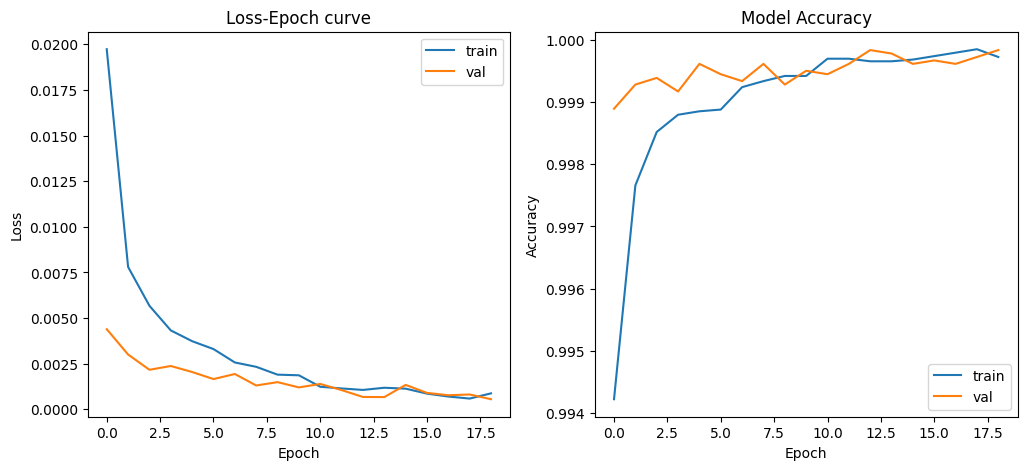

  0%|          | 0/2256 [00:00<?, ?it/s]

epoch 20 train acc 0.9997229609929078 loss 0.0009193426357074858


  0%|          | 0/564 [00:00<?, ?it/s]

epoch 20 valid acc 0.9996675531914894 loss 0.0007079664617060079


  0%|          | 0/2256 [00:00<?, ?it/s]

epoch 21 train acc 0.9997922207446809 loss 0.0006760342631036384


  0%|          | 0/564 [00:00<?, ?it/s]

epoch 21 valid acc 0.9997783687943262 loss 0.0008013970158282332


  0%|          | 0/2256 [00:00<?, ?it/s]

epoch 22 train acc 0.9998060726950354 loss 0.000717689718671114


  0%|          | 0/564 [00:00<?, ?it/s]

epoch 22 valid acc 0.9997783687943262 loss 0.0007067486716339527


  0%|          | 0/2256 [00:00<?, ?it/s]

epoch 23 train acc 0.9998337765957447 loss 0.0006962059534204597


  0%|          | 0/564 [00:00<?, ?it/s]

epoch 23 valid acc 0.9997783687943262 loss 0.0007596041834371827


  0%|          | 0/2256 [00:00<?, ?it/s]

epoch 24 train acc 0.9998891843971631 loss 0.0004798316666201042


  0%|          | 0/564 [00:00<?, ?it/s]

epoch 24 valid acc 0.9997783687943262 loss 0.0008091880791440681


  0%|          | 0/2256 [00:00<?, ?it/s]

epoch 25 train acc 0.9998753324468085 loss 0.00042605296735962644


  0%|          | 0/564 [00:00<?, ?it/s]

epoch 25 valid acc 0.9997783687943262 loss 0.0006913966659974626


  0%|          | 0/2256 [00:00<?, ?it/s]

epoch 26 train acc 0.9998614804964538 loss 0.00040655892961861115


  0%|          | 0/564 [00:00<?, ?it/s]

epoch 26 valid acc 0.9996121453900709 loss 0.001178693744791806


  0%|          | 0/2256 [00:00<?, ?it/s]

epoch 27 train acc 0.9999445921985816 loss 0.00037150280617976824


  0%|          | 0/564 [00:00<?, ?it/s]

epoch 27 valid acc 0.9997783687943262 loss 0.001050671454761809


  0%|          | 0/2256 [00:00<?, ?it/s]

epoch 28 train acc 0.9999307402482269 loss 0.0003213614490676124


  0%|          | 0/564 [00:00<?, ?it/s]

epoch 28 valid acc 0.999501329787234 loss 0.0011729369470244683


  0%|          | 0/2256 [00:00<?, ?it/s]

epoch 29 train acc 0.9998614804964538 loss 0.0004975008743730375


  0%|          | 0/564 [00:00<?, ?it/s]

epoch 29 valid acc 0.9997783687943262 loss 0.0007155687379145783


  0%|          | 0/2256 [00:00<?, ?it/s]

epoch 30 train acc 0.9998060726950354 loss 0.0007309458160573806


  0%|          | 0/564 [00:00<?, ?it/s]

epoch 30 valid acc 0.9998337765957447 loss 0.0006012961428777048


In [ ]:
for e in range(epoch_start+1, num_epochs+epoch_start+1):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    model.train()
    for batch_id, batch in enumerate(tqdm.notebook.tqdm(train_loader)):
        optimizer.zero_grad()

        img = batch[0].to(device)
        label = batch[1].to(device) # .squeeze(1) .float()

        out = model(img).squeeze(1)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    print("epoch {} train acc {} loss {}".format(e, tot_train_acc, mean_train_loss))

    model.eval()
    for batch_id, batch in enumerate(tqdm.notebook.tqdm(valid_loader)):

        img = batch[0].to(device)

        label = batch[1].to(device) # .squeeze(1)

        out = model(img).squeeze(1)
        loss = loss_fn(out, label)
        val_loss += loss.item()
        val_acc += calc_accuracy(out, label)

    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)

    print("epoch {} valid acc {} loss {}".format(e, tot_acc, mean_val_loss))

    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      best_val_loss = mean_val_loss
      save_checkpoint(e, labels, model, optimizer,
                      train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                      model_path, 'resnet18')

# Inference

In [ ]:
# def inference(img_path):

#     img = Image.open(img_path)

#     encoding = feature_extractor(images=img, return_tensors='pt')

#     outputs = model(encoding['pixel_values'])
#     result = outputs.logits.softmax(1)
#     result_dict = {}

#     for i, value in enumerate(result[0].tolist()):
#         result_dict[id2label[str(i)]] = value

#     result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)

#     return result

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import pickle
from collections import OrderedDict


In [ ]:
model = timm.create_model('resnet18',pretrained=True,num_classes=2)


In [ ]:
def load_checkpoint(model_path, filename):
    checkpoint = torch.load(os.path.join(model_path, f'{filename}.pt'))

    # 모델 로드
    model_dict = model.state_dict()
    model_dict.update(checkpoint['state_dict'])
    model.load_state_dict(model_dict)

    labels = checkpoint['label']

    return model, labels

In [ ]:
# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def predict_image(model, image_path, labels):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()

    image = transform(image).unsqueeze(0)  # 배치 차원 추가

    model.eval()  # 평가 모드로 전환
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)

    return labels[predicted.item()]


In [ ]:
# 체크포인트 로드
model_path = '/kaggle/working/'
filename = 'resnet18'
model, label = load_checkpoint(model_path, filename)

In [ ]:
label

['eye', 'skin']

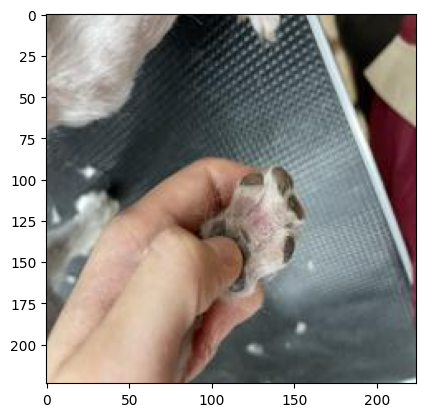

Predicted class: skin


In [ ]:
# 새로운 이미지로 예측 수행
image_path = '/kaggle/input/skin-eye-classification/skin/IMG_D_A1_034880.jpg'
predicted_class = predict_image(model, image_path, labels)
print(f"Predicted class: {predicted_class}")


## ---------


In [ ]:
# temp_file_1 = Image.open('/kaggle/input/skin-eye-classification/eye/crop_D0_034eae10-60a5-11ec-8402-0a7404972c70.jpg')
# temp_file_2 = Image.open('/kaggle/input/skin-eye-classification/skin/IMG_D_A1_034852.jpg')
# result = inference(temp_file_2)
# print(f'{result[0][0]}일 확률이 {int(result[0][1]*100)}%, {result[1][0]}일 확률이 {int(result[1][1]*100)}% 입니다.')

In [ ]:
result = inference(temp_file_2)
print(f'{result[0][0]}일 확률이 {int(result[0][1]*100)}%, {result[1][0]}일 확률이 {int(result[1][1]*100)}% 입니다.')

# ONNX

In [ ]:
!pip install onnx

In [ ]:
!pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.1/605.1 kB 28.3 MB/s eta 0:00:00


In [ ]:
import onnx, onnxscript

### save onnx file

In [ ]:
# torch_input = torch.randn(1, 3, 224, 224)
# onnx_program = torch.onnx.dynamo_export(model, torch_input)

In [ ]:
# onnx_program.save("resnet18.onnx")

In [ ]:
# # 또는 예전방식, 추출.
# torch.onnx.export(model, torch_input, "resnet18.onnx",
#                   export_params=True,        # 모델 매개변수를 파일에 저장
#                   opset_version=10,          # ONNX 버전
#                   do_constant_folding=True,  # 상수 폴딩 최적화
#                   input_names=['input'],     # 입력 레이어 이름
#                   output_names=['output'])   # 출력 레이어 이름

### load onnx file

https://netron.app/

In [ ]:
onnx_model = onnx.load("resnet18.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
# import onnxruntime as ort
# import numpy as np

# # ONNX 모델 로드
# ort_session = ort.InferenceSession("resnet18.onnx")
# input_data = np.random.randn(1, 3, 224, 224).astype(np.float32)
# outputs = ort_session.run(None, {"input": input_data})
# print(outputs)